# RETO 4
## Procesamiento del Lenguaje Natural
### Análisis de redes sociales en torno a #SOSMarMenor

In [186]:
import pandas as pd
import re
from matplotlib import pyplot as plt
from IPython.display import HTML
from nltk.tokenize import word_tokenize
import requests
from nltk.corpus import stopwords
from wordcloud import WordCloud

**a) exploración de datos**
En primer lugar, resulta recomendable realizar una revisión superficial de los datos como primera aproximación a su comprensión. Aplica las técnicas que te permita obtener algo de información sobre el dataset.

In [187]:
df = pd.read_csv('tweets.csv')

In [188]:
df

,Datetime,Tweet_Id,Text,Username,Reply_Count,Like_Count,Retweet_Count
0,2022-04-27 07:03:40+00:00,1519210655705972737,Agricultura y construcciones masivas y ningún...,Guzmani96580514,1,2,2
1,2022-04-27 06:47:37+00:00,1519206616431796224,El Instituto Oceanográfico alerta del riesgo d...,annamaryen,0,0,0
2,2022-04-27 06:45:23+00:00,1519206054457917440,#MarMenor\n#SOSMarMenor https://t.co/rC8vSspeKc,EcoantifaK,0,0,0
3,2022-04-27 05:57:18+00:00,1519193955166007297,#MarMenor\n#SOSMarMenor\n#AlertaMedioAmbiental...,Strikebis,0,0,0
4,2022-04-27 05:57:15+00:00,1519193940985012224,#SOSMarMenor \n@IEOoceanografia alerta del rie...,RafaSEF1,0,1,0
...,...,...,...,...,...,...,...
65573,2012-07-15 07:35:33+00:00,224406836554629120,Seguid destruyendo el Mar Menor y luego quejar...,zanguanga,0,3,13
65574,2012-07-11 12:26:33+00:00,223030514863448064,ANSE advierte a Valcárcel de que 'pagará el da...,zanguanga,0,0,0
65575,2012-07-10 18:41:13+00:00,222762417812291585,El Mar Menor podría ser un destino de primer n...,zanguanga,0,1,1
65576,2012-07-10 18:39:21+00:00,222761947647578113,Murcia podría haber sido un paraíso turístico ...,zanguanga,0,1,4


In [189]:
df.shape

(65578, 7)

In [190]:
df.describe()

,Tweet_Id,Reply_Count,Like_Count,Retweet_Count
count,6.557800e+04,65578.000000,65578.000000,65578.000000
mean,1.333442e+18,0.656196,11.595901,6.205602
std,1.249644e+17,5.124910,85.654005,49.232592
min,2.227583e+17,0.000000,0.000000,0.000000
25%,1.197089e+18,0.000000,0.000000,0.000000
50%,1.426811e+18,0.000000,2.000000,1.000000
75%,1.430935e+18,0.000000,6.000000,3.000000
max,1.519211e+18,682.000000,7624.000000,5479.000000


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65578 entries, 0 to 65577
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Datetime       65578 non-null  object
 1   Tweet_Id       65578 non-null  int64 
 2   Text           65578 non-null  object
 3   Username       65578 non-null  object
 4   Reply_Count    65578 non-null  int64 
 5   Like_Count     65578 non-null  int64 
 6   Retweet_Count  65578 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 3.5+ MB


In [192]:
df.isnull().sum()

Datetime         0
Tweet_Id         0
Text             0
Username         0
Reply_Count      0
Like_Count       0
Retweet_Count    0
dtype: int64

In [193]:
df.nunique()

Datetime         64553
Tweet_Id         65578
Text             64416
Username         10831
Reply_Count         98
Like_Count         486
Retweet_Count      356
dtype: int64

In [194]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

Tras la exploración inicial, se observa que el dataset está compuesto por casi 60.000 filas y 10 columnas. Cada una de estas filas hace referencia a un post de la red social Twitter y cada una de las columnas proporcionan la siguiente información:
- **DateTime**: fecha de publicación del post
- **Tweet_Id, Text**: identificador y contenido del post
- **Username**: información sobre el usuario que publica el post
- **Reply_Count, Like_Count, Retweet_Count**: respuestas, "me gusta" y retuits del post

b) preprocesamiento de texto
Como sabemos, pre-procesar un texto supone realizar diferentes tareas que lo dejen preparado para tareas posteriores. En este caso, como quizá puede ser útil no eliminar tokens referidos a otros hashtags o nombres de usuario (que pueden ser colectivos u organizaciones ciudadanas) que aparezcan en los mismos como parte de su contenido, ya es contenido que nos interesa preservar, puede ser aconsejable guardar los tuits pre-procesados de 2 formas: una en cuyo limpiado se incluyan hashtags y nombres de usuarios, y otra en la que se preserven como parte del tuit pre-procesado.

In [195]:
# Sanitize the tweets by removing unwanted data, but keeping hashtags and mentions
def sanitize_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)  # Remove URLs
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'[^\w\s#@]', '', tweet)  # Remove special characters (punctuation/emojis)
    return tweet


df['tweet_sanitized'] = df['Text'].apply(sanitize_tweet)
df[['Text', 'tweet_sanitized']].head()

,Text,tweet_sanitized
0,Agricultura y construcciones masivas y ningún...,agricultura y construcciones masivas y ningún...
1,El Instituto Oceanográfico alerta del riesgo d...,el instituto oceanográfico alerta del riesgo d...
2,#MarMenor\n#SOSMarMenor https://t.co/rC8vSspeKc,#marmenor\n#sosmarmenor
3,#MarMenor\n#SOSMarMenor\n#AlertaMedioAmbiental...,#marmenor\n#sosmarmenor\n#alertamedioambiental
4,#SOSMarMenor \n@IEOoceanografia alerta del rie...,#sosmarmenor \n@ieooceanografia alerta del rie...


In [196]:
# Remove hastahtags and mentions
def remove_hashtags_mentions(tweet):
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'\s{2,}', ' ', tweet)  # Remove multiple spaces
    return tweet


stop_words = set(stopwords.words('spanish'))


def remove_stop_words(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)


df['tweet_sanitized_no_hashtags_mentions'] = df['tweet_sanitized'].apply(remove_hashtags_mentions).apply(
    remove_stop_words)
df[['Text', 'tweet_sanitized_no_hashtags_mentions']]

,Text,tweet_sanitized_no_hashtags_mentions
0,Agricultura y construcciones masivas y ningún...,agricultura construcciones masivas ningún resp...
1,El Instituto Oceanográfico alerta del riesgo d...,instituto oceanográfico alerta riesgo nueva an...
2,#MarMenor\n#SOSMarMenor https://t.co/rC8vSspeKc,
3,#MarMenor\n#SOSMarMenor\n#AlertaMedioAmbiental...,
4,#SOSMarMenor \n@IEOoceanografia alerta del rie...,alerta riesgo nuevo episodio anoxia eutrofizac...
...,...,...
65573,Seguid destruyendo el Mar Menor y luego quejar...,seguid destruyendo mar menor luego quejaros tu...
65574,ANSE advierte a Valcárcel de que 'pagará el da...,anse advierte valcárcel pagará daño hecho mar ...
65575,El Mar Menor podría ser un destino de primer n...,mar menor podría ser destino primer nivel si p...
65576,Murcia podría haber sido un paraíso turístico ...,murcia podría haber sido paraíso turístico van...


In [217]:
stopwords = stop_words.add('holiiiiiiiiiiiiiiiiiii')
len(stop_words)

314

In [197]:
# TODO: make some graphs like average length of tweets.

**c) análisis de datos (“Exploratory Data Analysis”):**

En un tercer momento, puede ser interesante explorar en términos cuantitativos como parte de un
análisis más detallado de los datos. Como guía a los aspectos en los que puedes indagar, trata de
responder en el cuaderno las siguientes preguntas, argumentando tu respuesta:

- ¿En qué períodos ha existido más actividad ciudadana con relación al hashtag #SOSMarMenor?, ¿qué ocurrió en esos momentos?

C:\Users\jsanchez\AppData\Local\Temp\ipykernel_6036\250376836.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year-month'] = df['Datetime'].dt.to_period('M')


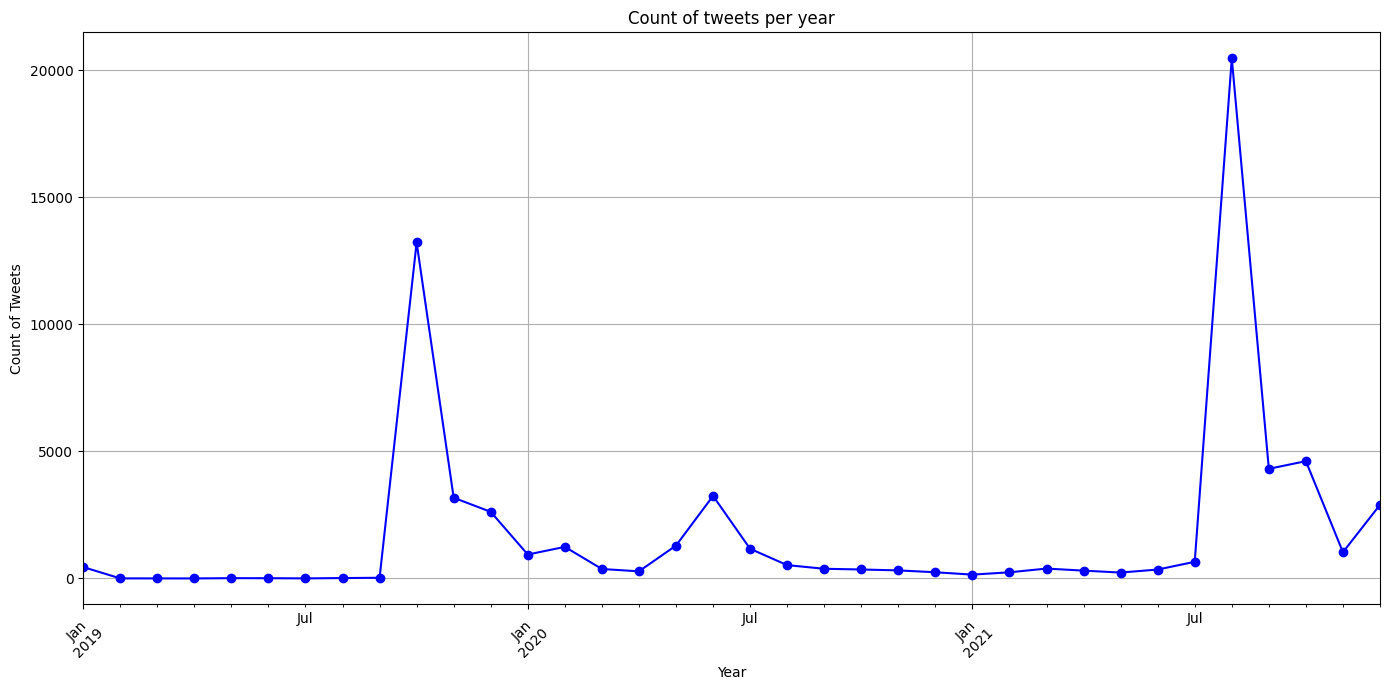

In [198]:
df['year-month'] = df['Datetime'].dt.to_period('M')
df['year-month'].clip(lower='2019-01', upper='2021-12',
                      inplace=True)  # Clip data to 2019 because nothing relevant happened before

# Group buy year-month and count the number of tweets
tweet_counts_by_month = df.groupby(df['year-month'])['Tweet_Id'].count()

# Plotting
plt.figure(figsize=(14, 7))
tweet_counts_by_month.plot(kind='line', marker='o', color='b')
plt.title('Count of tweets per year')
plt.xlabel('Year')
plt.ylabel('Count of Tweets')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

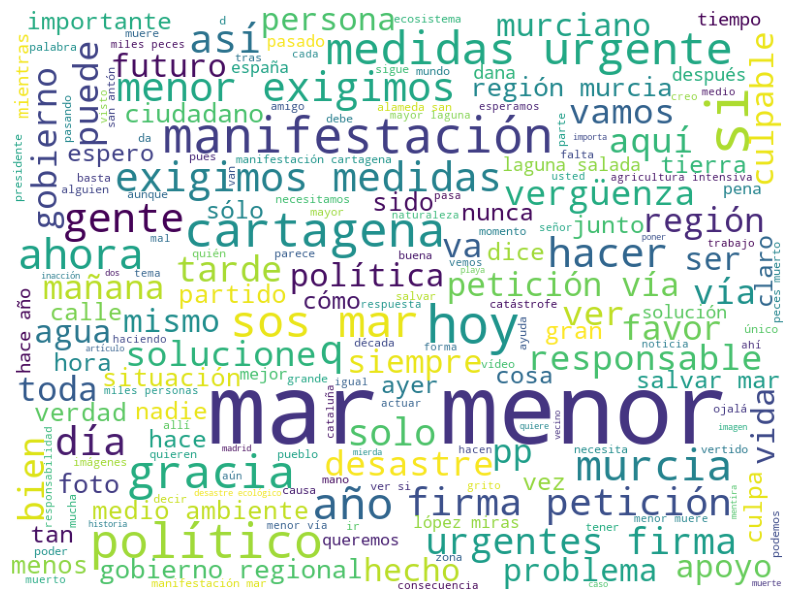

In [206]:
first_period = '2019-10'
tweets_first_period = df[df['year-month'] == first_period]

corpus = " ".join(sentence for sentence in tweets_first_period['tweet_sanitized_no_hashtags_mentions'])

wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=600,
    max_font_size=100
).generate(corpus)

# Display the generated WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

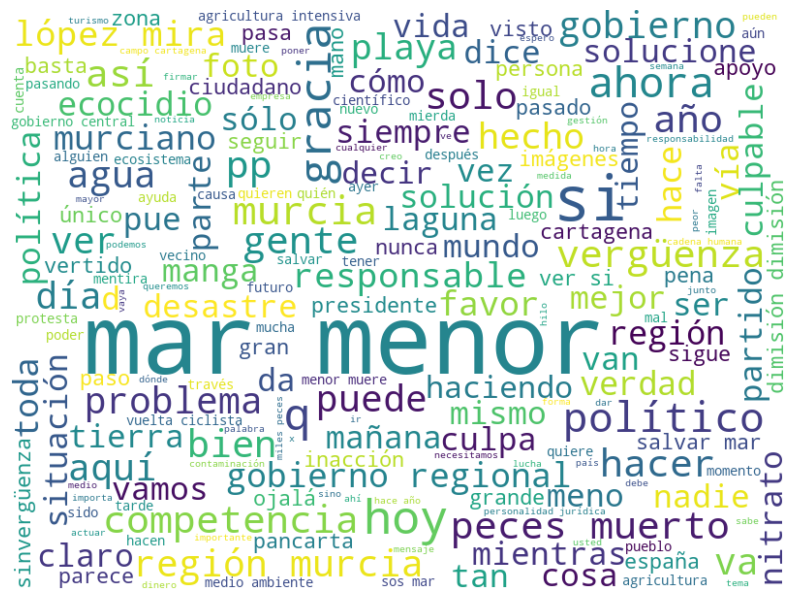

In [200]:
second_period = '2021-08'
tweets_second_period = df[df['year-month'] == second_period]

corpus = " ".join(sentence for sentence in tweets_second_period['tweet_sanitized_no_hashtags_mentions'])

wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=600,
    max_font_size=100
).generate(corpus)

# Display the generated WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- ¿Cuántos usuarios han generado tuits en relación con el hashtag #SOSMarMenor?

In [201]:
unique_users = df['Username'].nunique()
print(f'A total of {unique_users} unique users have made tweets using the hashtag')

A total of 10831 unique users have made tweets using the hashtag


- ¿Cuáles son los usuarios más activos?, ¿son partidos políticos, ONGs o plataformas ciudadanas, o personas particulares?

In [202]:
# Group buy year-month and count the number of tweets
tweet_counts_by_month = df.groupby(df['Username'])['Tweet_Id'].count()
tweet_counts_by_month.sort_values(ascending=False, inplace=True)
tweet_counts_by_month

Username
KlimoMur          1885
Miguel_Egea        893
Mariloliana        866
ono_murcia         743
sosmarmenorofi     728
                  ... 
JRRGtorquest         1
JRSaezJordan         1
JR_ABEN091           1
JRsexologo           1
022Christian         1
Name: Tweet_Id, Length: 10831, dtype: int64

- ¿Cuáles han sido los tuits más celebrados (i.e. retuiteados)?, ¿qué tipo de mensajes transmiten (de protesta, de indignación, de ánimo, de solidaridad)?

In [203]:
# Muestra un tuit a partir de su id y del nombre del usuario
def show_tweet(user, tweet_id):
    url = 'https://twitter.com/' + user + '/status/' + str(tweet_id)
    url_to_json = 'https://publish.twitter.com/oembed?url=%s' % url
    response = requests.get(url_to_json)
    html = response.json()["html"]
    display(HTML(html))

In [204]:
popular_tweets = df.sort_values(by='Retweet_Count', ascending=False)
popular_tweets

,Datetime,Tweet_Id,Text,Username,Reply_Count,Like_Count,Retweet_Count,tweet_sanitized,tweet_sanitized_no_hashtags_mentions,year-month
28178,2021-08-21 10:56:59+00:00,1429034792310517761,Hoy La Vuelta Ciclista a España llega a la Man...,JulianMaciasT,107,5238,5479,hoy la vuelta ciclista a españa llega a la man...,hoy vuelta ciclista españa llega manga mar men...,2021-08
54836,2019-10-30 17:48:47+00:00,1189600044762181636,En Cartagena la gente dice #SOSMarMenor https:...,mallemar,169,7624,3772,en cartagena la gente dice #sosmarmenor,cartagena gente dice,2019-10
64798,2019-10-12 19:02:47+00:00,1183095687543689216,Lo del Mar Menor es una JODIDA VERGÜENZA.\n\nN...,DrBioblogo,130,2488,3575,lo del mar menor es una jodida vergüenza\n\nno...,mar menor jodida vergüenza paran llegar videos...,2019-10
64839,2019-10-12 18:36:29+00:00,1183089070710362114,"El mar es vida, hay vida y nace vida. Menos el...",AlejandroSanz,377,5023,2640,el mar es vida hay vida y nace vida menos el #...,mar vida vida nace vida menos muere cada segun...,2019-10
22491,2021-08-22 10:01:53+00:00,1429383315891625988,#SOSMarMenor https://t.co/6U7kPvivdf,Hoyuelicos,15,7262,2369,#sosmarmenor,,2021-08
...,...,...,...,...,...,...,...,...,...,...
38369,2020-07-10 13:52:33+00:00,1281587115751596035,@AlbaladejoPress @laster Si hay que elegir ent...,isabellacer,0,1,0,@albaladejopress @laster si hay que elegir ent...,si elegir susto muerte inteligente elegir sust...,2020-07
14294,2021-08-28 20:10:16+00:00,1431710745666985997,Playa de los Alemanes.\n\n#AbracemosAlMarMenor...,ono_murcia,0,1,0,playa de los alemanes\n\n#abracemosalmarmenor\...,playa alemanes,2021-08
14293,2021-08-28 20:10:19+00:00,1431710758925217796,#SOSMarMenor https://t.co/KuLvPbgDLM,cornerfranke,0,0,0,#sosmarmenor,,2021-08
14291,2021-08-28 20:13:01+00:00,1431711436514996233,@LopezMirasF Diles a tus amos que dejen de cul...,unjuncoinfinito,0,1,0,@lopezmirasf diles a tus amos que dejen de cul...,diles amos dejen cultivar ilegalmente dejen ec...,2021-08


In [205]:
# Show the most popular tweets

for i in range(5):
    show_tweet(popular_tweets.iloc[i]['Username'], popular_tweets.iloc[i]['Tweet_Id'])